# Market Structure Analysis - Plotting Code

This notebook contains the plotting code for analyzing market structure as a complex system.


## Setup

Import libraries and set plotting style. All data (correlation matrices, eigenvalues, eigenvectors, entropies) should be provided as variables.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")


## 1. Correlation Matrix Heatmaps

Shows how strongly every stock moves with every other stock. Calm markets show sector blocks; crisis markets show uniform correlations.


NameError: name 'corr_calm' is not defined

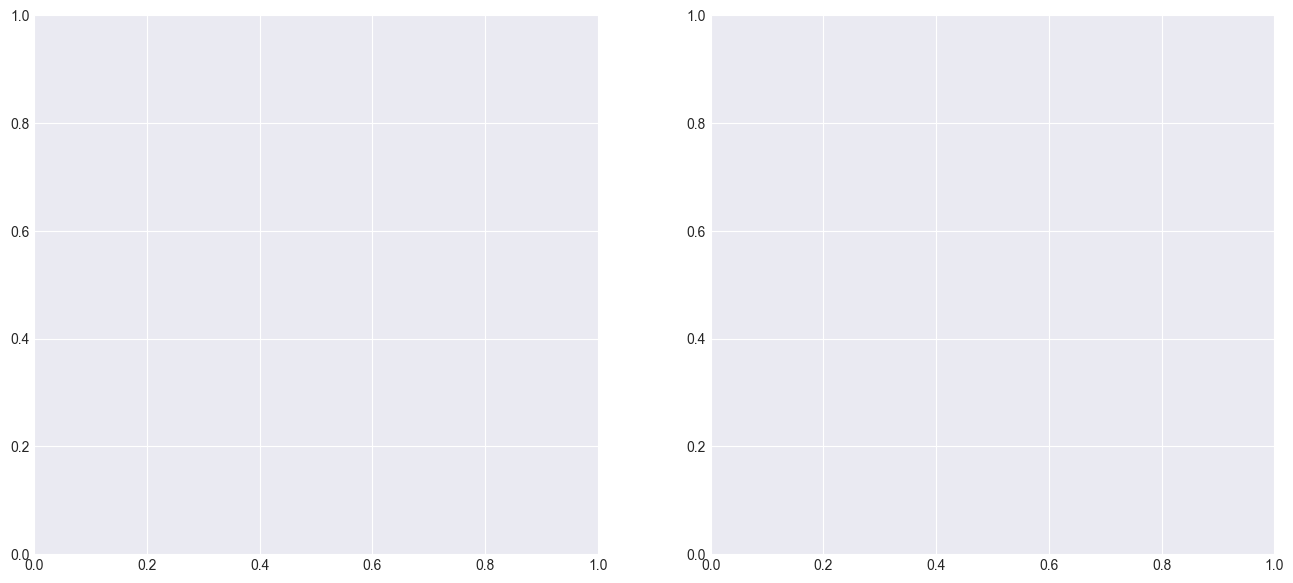

In [2]:
# Required variables: corr_calm, corr_crisis (N x N correlation matrices)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

im1 = axes[0].imshow(corr_calm, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0].set_title('Correlation Matrix: Calm Market\n(Structured, Sector Blocks Visible)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stock Index', fontsize=12)
axes[0].set_ylabel('Stock Index', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Correlation')

im2 = axes[1].imshow(corr_crisis, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[1].set_title('Correlation Matrix: Crisis Market\n(Uniform, Loss of Sector Structure)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stock Index', fontsize=12)
axes[1].set_ylabel('Stock Index', fontsize=12)
plt.colorbar(im2, ax=axes[1], label='Correlation')

plt.tight_layout()
plt.show()


## 2. Eigenvalue Spectrum vs Random Matrix Theory

Shows which eigenvalues are meaningful (signal) vs noise. Large eigenvalues indicate collective modes; bulk eigenvalues match random matrix theory predictions.


In [9]:
# Required variables: 
# - eigenvals_calm, eigenvals_crisis (sorted in descending order)
# - N (number of stocks), T (number of time points) for RMT bounds

# Random Matrix Theory prediction (Marchenko-Pastur)
Q = T / N
lambda_max = (1 + np.sqrt(1/Q))**2
lambda_min = max(0, (1 - np.sqrt(1/Q))**2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(range(1, N+1), eigenvals_calm, 'o-', markersize=4, label='Empirical Eigenvalues', linewidth=1.5)
axes[0].axhline(lambda_max, color='r', linestyle='--', linewidth=2, label=f'RMT Upper Bound ({lambda_max:.2f})')
axes[0].axhline(lambda_min, color='r', linestyle='--', linewidth=2, label=f'RMT Lower Bound ({lambda_min:.2f})')
axes[0].axhline(1.0, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Mean (1.0)')
axes[0].set_xlabel('Eigenvalue Rank', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('Eigenvalue Spectrum: Calm Market\n(Signal vs Noise)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, N+1), eigenvals_crisis, 'o-', markersize=4, label='Empirical Eigenvalues', linewidth=1.5, color='orange')
axes[1].axhline(lambda_max, color='r', linestyle='--', linewidth=2, label=f'RMT Upper Bound ({lambda_max:.2f})')
axes[1].axhline(lambda_min, color='r', linestyle='--', linewidth=2, label=f'RMT Lower Bound ({lambda_min:.2f})')
axes[1].axhline(1.0, color='gray', linestyle=':', linewidth=1, alpha=0.7, label='Mean (1.0)')
axes[1].set_xlabel('Eigenvalue Rank', fontsize=12)
axes[1].set_ylabel('Eigenvalue', fontsize=12)
axes[1].set_title('Eigenvalue Spectrum: Crisis Market\n(Dominant Market Mode)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'T' is not defined

## 3. Ranked Eigenvector Components

Shows how influence is distributed across stocks in each mode. Flat curves indicate high entropy (even distribution); peaked curves indicate low entropy (concentrated influence).


NameError: name 'N' is not defined

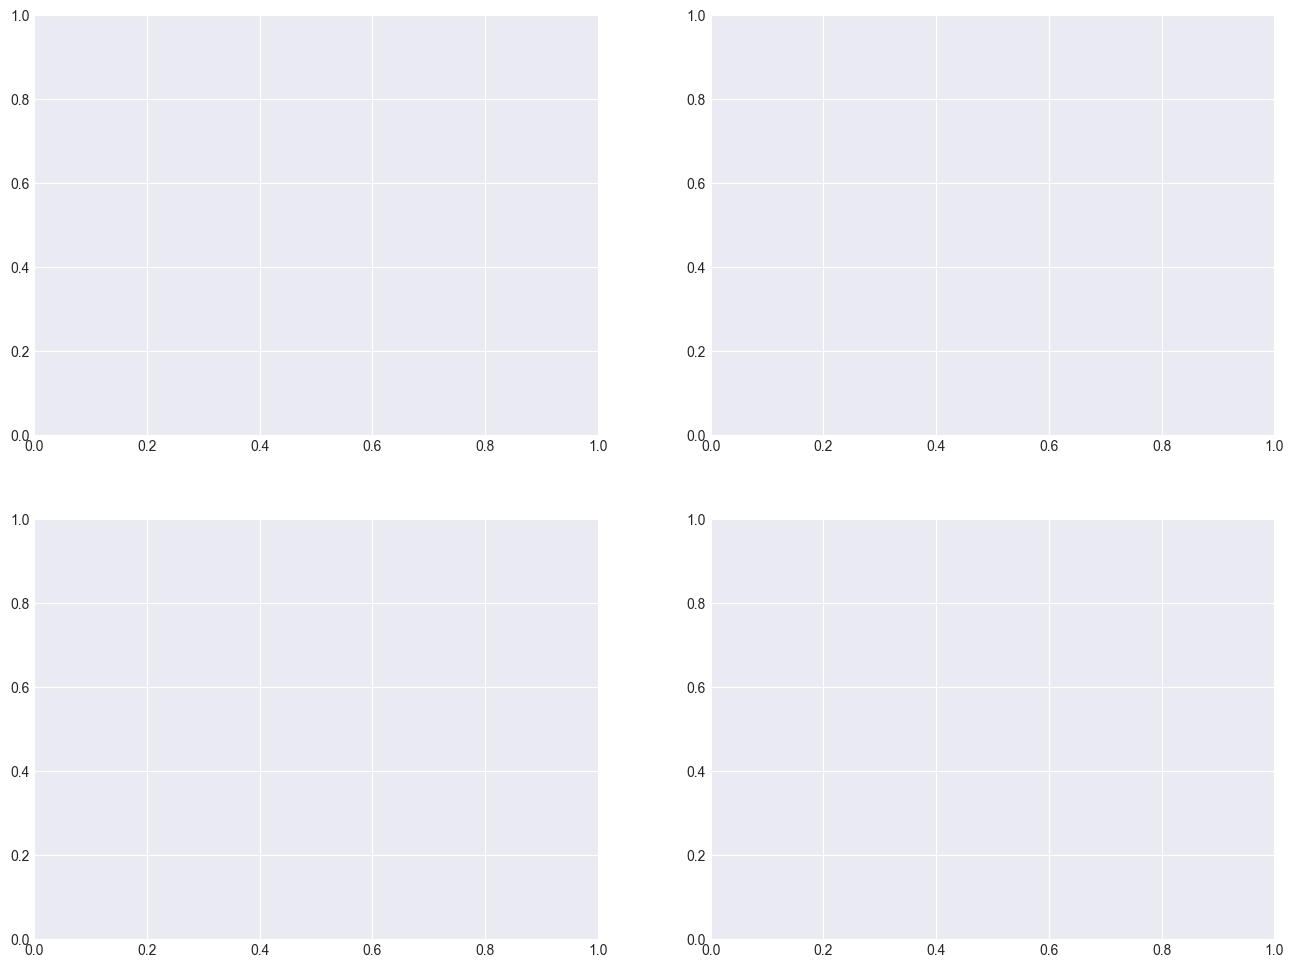

In [5]:
# Required variables:
# - market_sorted_calm, market_sorted_crisis (sorted absolute eigenvector components for market mode)
# - gr_sorted_calm, gr_sorted_crisis (sorted absolute eigenvector components for group+random mode)
# - H_market_calm, H_market_crisis, H_gr_calm, H_gr_crisis (entropy values)
# - N (number of stocks)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(range(1, N+1), market_sorted_calm, 'o-', markersize=3, linewidth=1.5)
axes[0, 0].set_xlabel('Stock Rank (by |component|)', fontsize=12)
axes[0, 0].set_ylabel('|Eigenvector Component|', fontsize=12)
axes[0, 0].set_title(f'Market Mode: Calm Market\n(Entropy H = {H_market_calm:.3f})', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(range(1, N+1), gr_sorted_calm, 'o-', markersize=3, linewidth=1.5, color='green')
axes[0, 1].set_xlabel('Stock Rank (by |component|)', fontsize=12)
axes[0, 1].set_ylabel('|Eigenvector Component|', fontsize=12)
axes[0, 1].set_title(f'Group + Random Mode: Calm Market\n(Entropy H = {H_gr_calm:.3f})', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(range(1, N+1), market_sorted_crisis, 'o-', markersize=3, linewidth=1.5, color='orange')
axes[1, 0].set_xlabel('Stock Rank (by |component|)', fontsize=12)
axes[1, 0].set_ylabel('|Eigenvector Component|', fontsize=12)
axes[1, 0].set_title(f'Market Mode: Crisis Market\n(Entropy H = {H_market_crisis:.3f})', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(1, N+1), gr_sorted_crisis, 'o-', markersize=3, linewidth=1.5, color='red')
axes[1, 1].set_xlabel('Stock Rank (by |component|)', fontsize=12)
axes[1, 1].set_ylabel('|Eigenvector Component|', fontsize=12)
axes[1, 1].set_title(f'Group + Random Mode: Crisis Market\n(Entropy H = {H_gr_crisis:.3f})', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Time Series of Entropy Measures

Shows how market order evolves over time. Entropy collapses during crises and recovers afterward, acting like an order parameter.


NameError: name 'entropy_full' is not defined

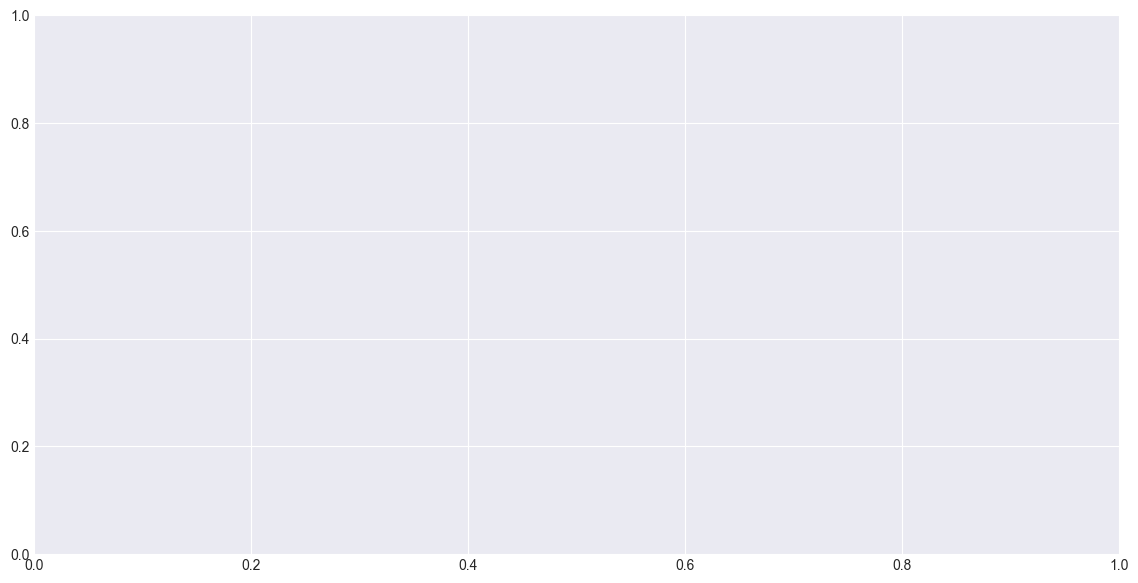

In [4]:
# Required variables:
# - entropy_full, entropy_market, entropy_gr (arrays of entropy values over time)
# - n_windows (number of time windows)
# - crisis_start, crisis_end (indices for crisis period)

fig, ax = plt.subplots(figsize=(14, 7))

time_points = np.arange(len(entropy_full))

ax.plot(time_points, entropy_full, label='Full Matrix Entropy', linewidth=2, alpha=0.8)
ax.plot(time_points, entropy_market, label='Market Mode Entropy', linewidth=2, alpha=0.8)
ax.plot(time_points, entropy_gr, label='Group + Random Entropy', linewidth=2, alpha=0.8)

# shade crisis period if crisis_start and crisis_end are defined
# ax.axvspan(crisis_start, crisis_end, alpha=0.2, color='red', label='Crisis Period')

ax.set_xlabel('Time Window', fontsize=12)
ax.set_ylabel('Entropy', fontsize=12)
ax.set_title('Time Series of Entropy Measures\n(Market Order Evolution)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Entropy Phase Space

Projects market states into 2D entropy space. Different regimes occupy distinct regions, showing phase separation without supervision.


In [3]:
# Required variables:
# - entropy_full, entropy_market, entropy_gr (arrays of entropy values)
# - regime_labels (list of 'calm' or 'crisis' for each time window, optional for coloring)

H_diff_market = np.abs(entropy_full - entropy_market)
H_diff_gr = np.abs(entropy_full - entropy_gr)

# Optional: color by regime if regime_labels is provided
if 'regime_labels' in locals():
    colors = ['blue' if regime == 'calm' else 'red' for regime in regime_labels]
else:
    colors = 'blue'  # Use single color if regime_labels not provided

fig, ax = plt.subplots(figsize=(10, 8))

n_points = len(H_diff_market)
if isinstance(colors, list):
    for i in range(n_points):
        ax.scatter(H_diff_market[i], H_diff_gr[i], c=colors[i], s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
else:
    ax.scatter(H_diff_market, H_diff_gr, c=colors, s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel(r'$|H - H_M|$ (Distance from Market Mode)', fontsize=12)
ax.set_ylabel(r'$|H - H_{GR}|$ (Distance from Group+Random Mode)', fontsize=12)
ax.set_title('Entropy Phase Space\n(Regime Separation)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

from matplotlib.patches import Patch
if isinstance(colors, list):
    legend_elements = [Patch(facecolor='blue', alpha=0.6, label='Calm Regime'),
                       Patch(facecolor='red', alpha=0.6, label='Crisis Regime')]
    ax.legend(handles=legend_elements, fontsize=11)

plt.tight_layout()
plt.show()


NameError: name 'entropy_full' is not defined